In [2]:
import pandas as pd
import json
from tqdm import tqdm 
from gensim.models import Word2Vec, FastText
from nltk.tokenize import word_tokenize
import numpy as np
import nltk
# bash
# pip install optuna
import optuna
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error, mean_squared_error


f:\university\master\nlp\hw\3\myenv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ela\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

part 1

In [1]:
# 1.1
import pandas as pd
import json
from tqdm import tqdm
from collections import defaultdict

# Function to check if a business is a restaurant
def is_restaurant(categories):
    if not isinstance(categories, str):
        return False
    return 'Restaurants' in categories

# Load businesses and filter for restaurants
businesses = pd.read_json('yelp_academic_dataset_business.json', lines=True)
restaurants = businesses[businesses['categories'].apply(is_restaurant)]
restaurant_ids = set(restaurants['business_id'])

# Process reviews
user_restaurants = defaultdict(set)   # user_id -> set of restaurant IDs reviewed
biz_users = defaultdict(set)          # business_id -> set of users who reviewed it
valid_reviews = []

with open('yelp_academic_dataset_review.json', 'r', encoding='utf-8') as f:
    for line in tqdm(f, desc="Processing reviews"):
        review = json.loads(line)
        if review['business_id'] in restaurant_ids:
            valid_reviews.append(review)
            user = review['user_id']
            biz = review['business_id']
            user_restaurants[user].add(biz)
            biz_users[biz].add(user)   # ⬅️ Important fix: collect users for each business

# User filter: must have reviewed at least 100 different restaurants
qualified_users = {u for u, biz_set in user_restaurants.items() if len(biz_set) >= 100}

# Restaurant filter: must be reviewed by at least 1000 unique users
qualified_biz = {b for b, user_set in biz_users.items() if len(user_set) >= 1000}

# Final review filtering
final_reviews = [
    r for r in valid_reviews
    if r['user_id'] in qualified_users and r['business_id'] in qualified_biz
]

# Save filtered reviews
with open('filtered_reviews.json', 'w', encoding='utf-8') as f:
    for r in final_reviews:
        f.write(json.dumps(r) + '\n')

# Save number of unique restaurants reviewed per user
user_stats = pd.DataFrame([
    {'user_id': user, 'unique_restaurant_count': len(biz_ids)}
    for user, biz_ids in user_restaurants.items()
])

# Save to CSV file
user_stats.to_csv('user_restaurant_counts.csv', index=False)

print("📄 File 'user_restaurant_counts.csv' saved. It contains the number of unique restaurants each user has reviewed.")

# Summary report
print("Users:", len(qualified_users))
print("Restaurants:", len(qualified_biz))
print("Reviews:", len(final_reviews))

Processing reviews: 6990280it [05:55, 19665.21it/s]


📄 File 'user_restaurant_counts.csv' saved. It contains the number of unique restaurants each user has reviewed.
Users: 2121
Restaurants: 296
Reviews: 23924


In [ ]:

# 1.2
filtered_reviews = pd.read_json('filtered_reviews.json', lines=True)

# حالا می‌تونی ادامه بدی
filtered_reviews['date'] = pd.to_datetime(filtered_reviews['date'])
sorted_reviews = filtered_reviews.sort_values('date')

train = sorted_reviews.iloc[:20000]
rest = sorted_reviews.iloc[20000:]
valid = rest.iloc[:len(rest)//2]
test = rest.iloc[len(rest)//2:]

# ذخیره فایل‌ها
train.to_json('train.json', lines=True, orient='records')
valid.to_json('valid.json', lines=True, orient='records')
test.to_json('test.json', lines=True, orient='records')

print("Train size:", len(train))
print("Validation size:", len(valid))
print("Test size:", len(test))


Train size: 20000
Validation size: 1962
Test size: 1962


part 2

In [3]:

# 2.1
import pandas as pd
from gensim.models import Word2Vec, FastText
from nltk.tokenize import word_tokenize

def preprocess(text):
    return [w.lower() for w in word_tokenize(text)]

# بارگذاری و پیش‌پردازش
train_reviews = pd.read_json('train.json', lines=True)
sentences = train_reviews['text'].apply(preprocess).tolist()

# آموزش مدل‌ها
w2v_model = Word2Vec(sentences, seed=1234)
ft_model = FastText(sentences, seed=1234)

# تابع برای تبدیل لیست مشابه‌ها به DataFrame مرتب
def format_similar_words(model, word, topn=15):
    similar = model.wv.most_similar(word, topn=topn)
    return pd.DataFrame(similar, columns=['Word', 'Similarity'])

# ایجاد جدول نهایی
df_tasty = pd.concat([
    format_similar_words(ft_model, 'tasty').rename(columns={'Word': 'FastText', 'Similarity': 'FT_Sim'}),
    format_similar_words(w2v_model, 'tasty').rename(columns={'Word': 'Word2Vec', 'Similarity': 'W2V_Sim'})
], axis=1)

df_give = pd.concat([
    format_similar_words(ft_model, 'give').rename(columns={'Word': 'FastText', 'Similarity': 'FT_Sim'}),
    format_similar_words(w2v_model, 'give').rename(columns={'Word': 'Word2Vec', 'Similarity': 'W2V_Sim'})
], axis=1)

# نمایش زیباتر
print("\n🔍 Top 15 Similar Words to 'tasty'")
print(df_tasty.to_string(index=False))

print("\n🔍 Top 15 Similar Words to 'give'")
print(df_give.to_string(index=False))



🔍 Top 15 Similar Words to 'tasty'
  FastText   FT_Sim      Word2Vec  W2V_Sim
    tasty- 0.957964         yummy 0.833816
     good- 0.839100     delicious 0.813541
 delicious 0.824517          good 0.807784
 flavorful 0.821973     flavorful 0.733744
      good 0.821693        delish 0.700442
delicious- 0.805538    satisfying 0.698690
   goodbye 0.793263       filling 0.669034
     -good 0.792252 disappointing 0.657894
flavorfull 0.790689         bland 0.622572
  delicacy 0.790058    refreshing 0.619355
     pasty 0.788990        hearty 0.618211
flavourful 0.785256   outstanding 0.614990
suspicious 0.784993        strong 0.610984
  delicous 0.779898      tempting 0.610952
     yummy 0.777956   scrumptious 0.605299

🔍 Top 15 Similar Words to 'give'
FastText   FT_Sim Word2Vec  W2V_Sim
 forgive 0.823551    bring 0.604657
   agave 0.748712 consider 0.583525
   given 0.746449    allow 0.577139
   gives 0.745981      add 0.566688
    gave 0.703354  deserve 0.566082
     ive 0.694540     rate 

In [8]:
# 2.1
import pandas as pd
from gensim.models import Word2Vec, FastText
from nltk.tokenize import word_tokenize

# --- Preprocessing Function ---
def preprocess(text):
    return [w.lower() for w in word_tokenize(text)]

# --- Load and Preprocess Training Reviews ---
train_reviews = pd.read_json('train.json', lines=True)
sentences = train_reviews['text'].apply(preprocess).tolist()


# --- Train Embedding Models ---
w2v_model = Word2Vec(sentences, vector_size=100, window=5, min_count=5, sg=1, seed=1234)  # SGNS
ft_model = FastText(sentences, vector_size=100, window=5, min_count=5, sg=1, seed=1234)   # SGNS with subword info

# --- Function to Format Similar Words ---
def format_similar_words(model, word, topn=15):
    similar = model.wv.most_similar(word, topn=topn)
    return pd.DataFrame(similar, columns=['Word', 'Similarity'])

# --- Generate Tables for 'tasty' and 'give' ---
df_tasty = pd.concat([
    format_similar_words(ft_model, 'tasty').rename(columns={'Word': 'FastText', 'Similarity': 'FT_Sim'}),
    format_similar_words(w2v_model, 'tasty').rename(columns={'Word': 'Word2Vec', 'Similarity': 'W2V_Sim'})
], axis=1)

df_give = pd.concat([
    format_similar_words(ft_model, 'give').rename(columns={'Word': 'FastText', 'Similarity': 'FT_Sim'}),
    format_similar_words(w2v_model, 'give').rename(columns={'Word': 'Word2Vec', 'Similarity': 'W2V_Sim'})
], axis=1)

# --- Display Results ---
print("\n🔍 Top 15 Similar Words to 'tasty'")
print(df_tasty.to_string(index=False))

print("\n🔍 Top 15 Similar Words to 'give'")
print(df_give.to_string(index=False))

# --- Optional: Try OOV Word ---
print("\n❓ OOV Example (word: 'givez'):")
try:
    print("FastText:", ft_model.wv['givez'][:5])  # shows vector head
except KeyError:
    print("FastText: OOV not handled.")
try:
    print("Word2Vec:", w2v_model.wv['givez'][:5])
except KeyError:
    print("Word2Vec: ❌ OOV not in vocabulary")



🔍 Top 15 Similar Words to 'tasty'
     FastText   FT_Sim      Word2Vec  W2V_Sim
       tasty- 0.926242     delicious 0.868959
    delicious 0.857806         yummy 0.817968
   delicious- 0.837358          good 0.784924
    flavorful 0.803806     flavorful 0.772891
   flavorfull 0.801029         delic 0.769139
        yummy 0.796259      passable 0.745104
   flavourful 0.792423  unimpressive 0.736847
         good 0.775880  over-dressed 0.724674
    delicioso 0.773783 well-prepared 0.721848
        good- 0.757103     portioned 0.720370
     delicous 0.757069        tastey 0.718796
well-flavored 0.757052         good- 0.716557
        delic 0.753661   scrumptious 0.716499
  deliciously 0.744429        delish 0.714353
        yummo 0.743477      absurdly 0.711759

🔍 Top 15 Similar Words to 'give'
 FastText   FT_Sim  Word2Vec  W2V_Sim
   giving 0.739561    giving 0.705823
  forgive 0.684235      bump 0.703141
  deserve 0.681480   deserve 0.672059
     gave 0.677911      gave 0.663112
forgi

In [4]:
# --- Document Embedding Function ---
def doc_embedding(text, model, aggregation='mean'):
    words = preprocess(text)
    vectors = [model.wv[w] for w in words if w in model.wv]
    if not vectors:
        return np.zeros(model.vector_size)
    if aggregation == 'sum':
        return np.sum(vectors, axis=0)
    return np.mean(vectors, axis=0)

# مثال استفاده:
# X_train = np.array([doc_embedding(text, w2v_model, aggregation='mean') for text in train_reviews['text']])


paer 3

In [ ]:
# 3.1
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
import numpy as np

def build_embedding_model(sentences, method='word2vec', **kwargs):
    if method == 'word2vec':
        model = Word2Vec(sentences, **kwargs)
    elif method == 'fasttext':
        model = FastText(sentences, **kwargs)
    else:
        raise ValueError("Unknown embedding method")
    return model

def tfidf_weighted(text, model, vectorizer):
    words = preprocess(text)
    vec = vectorizer.transform([text])
    vec_size = model.vector_size
    result = np.zeros(vec_size)
    total_weight = 0
    for word in words:
        if word in model.wv and word in vectorizer.vocabulary_:
            tfidf = vec[0, vectorizer.vocabulary_[word]]
            result += model.wv[word] * tfidf
            total_weight += tfidf
    return result / total_weight if total_weight else result

def get_doc_embedding_func(model, aggregation='mean', tfidf_vectorizer=None):
    def embed(text):
        words = preprocess(text)
        if aggregation == 'sum':
            vecs = [model.wv[w] for w in words if w in model.wv]
            return np.sum(vecs, axis=0) if vecs else np.zeros(model.vector_size)
        elif aggregation == 'mean':
            vecs = [model.wv[w] for w in words if w in model.wv]
            return np.mean(vecs, axis=0) if vecs else np.zeros(model.vector_size)
        elif aggregation == 'tfidf':
            return tfidf_weighted(text, model, tfidf_vectorizer)
        else:
            raise ValueError("Unknown aggregation")
    return embed

def evaluate_model(model, X_train, y_train, X_valid, y_valid):
    model.fit(X_train, y_train)
    preds = model.predict(X_valid)
    return r2_score(y_valid, preds)

def run_pipeline(embedding_type='word2vec',
                 aggregation='mean',
                 regression_model='ridge',
                 use_scaling=False,
                 embedding_params={},
                 reg_params={}):
    
    # Step 1: prepare data
    texts = train['text'].tolist()
    tokenized = [preprocess(t) for t in texts]
    model = build_embedding_model(tokenized, method=embedding_type, **embedding_params)

    if aggregation == 'tfidf':
        from sklearn.feature_extraction.text import TfidfVectorizer
        vectorizer = TfidfVectorizer(tokenizer=preprocess)
        vectorizer.fit(texts)
    else:
        vectorizer = None

    embed_func = get_doc_embedding_func(model, aggregation, vectorizer)

    # Step 2: embed train and valid
    X_train = np.array([embed_func(t) for t in train['text']])
    X_valid = np.array([embed_func(t) for t in valid['text']])
    y_train = train['stars'].values
    y_valid = valid['stars'].values

    # Step 3: Feature scaling
    if use_scaling:
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_valid = scaler.transform(X_valid)

    # Step 4: Choose regressor
    if regression_model == 'ridge':
        reg = Ridge(**reg_params)
    elif regression_model == 'linear':
        reg = LinearRegression()
    elif regression_model == 'rf':
        reg = RandomForestRegressor(**reg_params)
    else:
        raise ValueError("Unknown regression model")

    r2 = evaluate_model(reg, X_train, y_train, X_valid, y_valid)
    print(f"[{embedding_type.upper()}-{aggregation}] → {regression_model} R² score: {r2:.4f}")
    return r2

# Example usage
run_pipeline(
    embedding_type='word2vec',
    aggregation='mean',
    regression_model='ridge',
    embedding_params={'vector_size': 100, 'window': 5, 'sg': 1, 'min_count': 5, 'epochs': 10, 'seed': 1234},
    reg_params={'alpha': 1.0},
    use_scaling=True
)


[WORD2VEC-mean] → ridge R² score: 0.3586


0.35863232612609863

part 4

3

In [5]:
import pandas as pd
import numpy as np
from gensim.models import Word2Vec, FastText, Doc2Vec
from gensim.models.doc2vec import TaggedDocument
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
# nltk.download('punkt')
from nltk.tokenize import word_tokenize
import random

# ---------------------------------
# تنظیمات اولیه و فایل‌ها
# ---------------------------------
SEED = 1234
random.seed(SEED)
np.random.seed(SEED)

embedding_type = 'word2vec'     # 'fasttext' یا 'doc2vec'
aggregation_type = 'mean'       # 'mean', 'tfidf', 'doc2vec'
regressor_type = 'RandomForest' # 'LinearRegression', 'SVR', 'RandomForest'

vector_size = 100
window = 5
epochs = 20
sg = 1  # 1=SGNS, 0=CBOW

# ---------------------------------
# 1. Load Train Data and Preprocess
# ---------------------------------
train_df = pd.read_json('train.json', lines=True)

def preprocess(text):
    return [w.lower() for w in word_tokenize(text)]

train_df['tokens'] = train_df['text'].apply(preprocess)

# ---------------------------------
# 2. Train Word Embedding
# ---------------------------------
sentences = train_df['tokens'].tolist()

def train_embedding(sentences, method='word2vec'):
    if method == 'word2vec':
        model = Word2Vec(vector_size=vector_size, window=window, sg=sg, seed=SEED, min_count=2)
        model.build_vocab(sentences)
        model.train(sentences, total_examples=model.corpus_count, epochs=epochs)
    elif method == 'fasttext':
        model = FastText(vector_size=vector_size, window=window, sg=sg, seed=SEED, min_count=2)
        model.build_vocab(sentences)
        model.train(sentences, total_examples=model.corpus_count, epochs=epochs)
    else:
        model = None
    return model

if embedding_type in ['word2vec', 'fasttext']:
    embedding_model = train_embedding(sentences, method=embedding_type)

# ---------------------------------
# 3. Document Embedding Aggregation
# ---------------------------------
def mean_embedding(tokens, model):
    vectors = [model.wv[w] for w in tokens if w in model.wv]
    return np.mean(vectors, axis=0) if vectors else np.zeros(vector_size)

def tfidf_weighted_embedding(df, model):
    tfidf = TfidfVectorizer()
    tfidf.fit(df['text'])
    idf_dict = dict(zip(tfidf.get_feature_names_out(), tfidf.idf_))
    embeddings = []
    for tokens in df['tokens']:
        weighted = [model.wv[w] * idf_dict.get(w, 0.0) for w in tokens if w in model.wv]
        weights = [idf_dict.get(w, 0.0) for w in tokens if w in model.wv]
        if weighted:
            doc_vec = np.sum(weighted, axis=0) / np.sum(weights)
        else:
            doc_vec = np.zeros(vector_size)
        embeddings.append(doc_vec)
    return np.array(embeddings)

def doc2vec_embedding(df):
    tagged = [TaggedDocument(words=t, tags=[str(i)]) for i, t in enumerate(df['tokens'])]
    model = Doc2Vec(tagged, vector_size=vector_size, window=window, epochs=epochs, seed=SEED)
    return np.array([model.dv[str(i)] for i in range(len(df))])

if aggregation_type == 'doc2vec' or embedding_type == 'doc2vec':
    X = doc2vec_embedding(train_df)
else:
    if aggregation_type == 'mean':
        X = np.vstack(train_df['tokens'].apply(lambda x: mean_embedding(x, embedding_model)))
    elif aggregation_type == 'tfidf':
        X = tfidf_weighted_embedding(train_df, embedding_model)

y = train_df['stars'].values  # هدف: امتیاز 1 تا 5

# ---------------------------------
# 4. Feature Manipulation (Optional)
# ---------------------------------
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ---------------------------------
# 5. Regression Model Training
# ---------------------------------
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=SEED)

regressors = {
    'LinearRegression': LinearRegression(),
    'SVR': SVR(kernel='rbf', C=1.0),
    'RandomForest': RandomForestRegressor(n_estimators=100, max_depth=5, random_state=SEED)
}

regressor = regressors[regressor_type]
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5

print(f" Model: {regressor_type} | Embedding: {embedding_type} | Aggregation: {aggregation_type} | RMSE: {rmse:.4f}")


 Model: RandomForest | Embedding: word2vec | Aggregation: mean | RMSE: 0.8325


In [ ]:
# optuna_hyperparameter_tuning.py
import optuna
from optuna.samplers import TPESampler
from gensim.models import Word2Vec, FastText, Doc2Vec
from gensim.models.doc2vec import TaggedDocument
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score
import pandas as pd
import numpy as np
from nltk.tokenize import word_tokenize

# Preprocess
train_reviews = pd.read_json('train.json', lines=True)
valid_reviews = pd.read_json('valid.json', lines=True)

def preprocess(text):
    return [w.lower() for w in word_tokenize(text)]

sentences = train_reviews['text'].apply(preprocess).tolist()
val_texts = valid_reviews['text'].apply(preprocess)
y_val = valid_reviews['stars'].values

# Word2Vec & FastText Embedding Function
def embed_docs(model, docs, vector_size):
    result = []
    for tokens in docs:
        vectors = [model.wv[w] for w in tokens if w in model.wv]
        result.append(np.mean(vectors, axis=0) if vectors else np.zeros(vector_size))
    return np.array(result)

# Doc2Vec Embedding Function
def embed_docs_d2v(model, docs, vector_size):
    return np.array([model.infer_vector(toks) for toks in docs])

# Template for study

def run_study(model_type):
    def objective(trial):
        vector_size = trial.suggest_categorical("vector_size", [100, 150, 200, 250, 300])
        epochs = trial.suggest_int("epochs", 10, 30)
        min_count = trial.suggest_int("min_count", 1, 5)

        if model_type.startswith("word2vec") or model_type.startswith("fastText"):
            window = trial.suggest_int("window", 3, 10)
            sg = 1 if "SGNS" in model_type else 0

            if model_type.startswith("word2vec"):
                model = Word2Vec(sentences, vector_size=vector_size, window=window, 
                                 epochs=epochs, min_count=min_count, sg=sg, seed=SEED)
            else:
                min_n = trial.suggest_int("min_n", 2, 4)
                max_n = trial.suggest_int("max_n", 5, 6)
                model = FastText(sentences, vector_size=vector_size, window=window, 
                                 epochs=epochs, min_count=min_count, sg=sg, 
                                 min_n=min_n, max_n=max_n, seed=SEED)

            X = embed_docs(model, val_texts, vector_size)

        elif model_type.startswith("doc2vec"):
            tagged_docs = [TaggedDocument(words=t, tags=[i]) for i, t in enumerate(sentences)]
            dm = 1 if "DM" in model_type else 0
            model = Doc2Vec(tagged_docs, vector_size=vector_size, epochs=epochs, 
                            min_count=min_count, dm=dm, seed=SEED)
            X = embed_docs_d2v(model, val_texts, vector_size)

        reg = Ridge()
        reg.fit(X, y_val)
        preds = reg.predict(X)
        return r2_score(y_val, preds)

    sampler = TPESampler(seed=SEED)
    study = optuna.create_study(direction="maximize", sampler=sampler)
    study.optimize(objective, n_trials=50)
    print(f"\n===== {model_type} =====")
    print("Best trial:", study.best_trial)
    try:
        import optuna.visualization as vis
        fig = vis.plot_param_importances(study)
        fig.show()
    except:
        pass
    return study

if __name__ == '__main__':
    settings = [
        'word2vec-SGNS', 'word2vec-CBOW',
        'fastText-SGNS', 'fastText-CBOW',
        'doc2vec-DM', 'doc2vec-DBOW'
    ]

    results = {}
    for setting in settings:
        results[setting] = run_study(setting)

    # Optional: Save studies
    for name, study in results.items():
        study.trials_dataframe().to_csv(f'{name}_optuna_trials.csv', index=False)


[I 2025-06-28 00:36:23,175] A new study created in memory with name: no-name-72f2a10b-78f4-40d5-bfb7-e7ef1fe509e9
[I 2025-06-28 00:45:39,841] Trial 0 finished with value: 0.4077486991882324 and parameters: {'vector_size': 150, 'epochs': 13, 'min_count': 1, 'window': 9}. Best is trial 0 with value: 0.4077486991882324.
[I 2025-06-28 00:52:01,057] Trial 1 finished with value: 0.43179863691329956 and parameters: {'vector_size': 250, 'epochs': 14, 'min_count': 1, 'window': 4}. Best is trial 1 with value: 0.43179863691329956.
[I 2025-06-28 00:57:51,547] Trial 2 finished with value: 0.43681877851486206 and parameters: {'vector_size': 300, 'epochs': 12, 'min_count': 2, 'window': 5}. Best is trial 2 with value: 0.43681877851486206.
[I 2025-06-28 01:01:08,969] Trial 3 finished with value: 0.391482949256897 and parameters: {'vector_size': 150, 'epochs': 10, 'min_count': 4, 'window': 4}. Best is trial 2 with value: 0.43681877851486206.
[I 2025-06-28 01:05:37,580] Trial 4 finished with value: 0.421


===== word2vec-SGNS =====
Best trial: FrozenTrial(number=44, state=1, values=[0.46813344955444336], datetime_start=datetime.datetime(2025, 6, 28, 9, 30, 39, 891179), datetime_complete=datetime.datetime(2025, 6, 28, 9, 51, 21, 857919), params={'vector_size': 300, 'epochs': 30, 'min_count': 1, 'window': 9}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'vector_size': CategoricalDistribution(choices=(100, 150, 200, 250, 300)), 'epochs': IntDistribution(high=30, log=False, low=10, step=1), 'min_count': IntDistribution(high=5, log=False, low=1, step=1), 'window': IntDistribution(high=10, log=False, low=3, step=1)}, trial_id=44, value=None)


[I 2025-06-28 11:16:29,960] A new study created in memory with name: no-name-a6c22af1-1122-401a-911e-8fec781bdc39
[I 2025-06-28 11:18:05,664] Trial 0 finished with value: 0.41857314109802246 and parameters: {'vector_size': 150, 'epochs': 13, 'min_count': 1, 'window': 9}. Best is trial 0 with value: 0.41857314109802246.
[I 2025-06-28 11:19:49,306] Trial 1 finished with value: 0.47096413373947144 and parameters: {'vector_size': 250, 'epochs': 14, 'min_count': 1, 'window': 4}. Best is trial 1 with value: 0.47096413373947144.
[I 2025-06-28 11:21:16,704] Trial 2 finished with value: 0.47289347648620605 and parameters: {'vector_size': 300, 'epochs': 12, 'min_count': 2, 'window': 5}. Best is trial 2 with value: 0.47289347648620605.
[I 2025-06-28 11:22:13,914] Trial 3 finished with value: 0.4083157181739807 and parameters: {'vector_size': 150, 'epochs': 10, 'min_count': 4, 'window': 4}. Best is trial 2 with value: 0.47289347648620605.
[I 2025-06-28 11:23:24,665] Trial 4 finished with value: 0.

In [2]:
# test 1 trial
# optuna_hyperparameter_tuning.py
import optuna
from optuna.samplers import TPESampler
from gensim.models import Word2Vec, FastText, Doc2Vec
from gensim.models.doc2vec import TaggedDocument
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score
import pandas as pd
import numpy as np
from nltk.tokenize import word_tokenize

SEED = 1234

# Preprocess
train_reviews = pd.read_json('train.json', lines=True)
valid_reviews = pd.read_json('valid.json', lines=True)

def preprocess(text):
    return [w.lower() for w in word_tokenize(text)]

sentences = train_reviews['text'].apply(preprocess).tolist()
val_texts = valid_reviews['text'].apply(preprocess)
y_val = valid_reviews['stars'].values

# Word2Vec & FastText Embedding Function
def embed_docs(model, docs, vector_size):
    result = []
    for tokens in docs:
        vectors = [model.wv[w] for w in tokens if w in model.wv]
        result.append(np.mean(vectors, axis=0) if vectors else np.zeros(vector_size))
    return np.array(result)

# Doc2Vec Embedding Function
def embed_docs_d2v(model, docs, vector_size):
    return np.array([model.infer_vector(toks) for toks in docs])

# Template for study

def run_study(model_type):
    def objective(trial):
        vector_size = trial.suggest_categorical("vector_size", [100, 150, 200, 250, 300])
        epochs = trial.suggest_int("epochs", 10, 30)
        min_count = trial.suggest_int("min_count", 1, 5)

        if model_type.startswith("word2vec") or model_type.startswith("fastText"):
            window = trial.suggest_int("window", 3, 10)
            sg = 1 if "SGNS" in model_type else 0

            if model_type.startswith("word2vec"):
                model = Word2Vec(sentences, vector_size=vector_size, window=window, 
                                 epochs=epochs, min_count=min_count, sg=sg, seed=SEED)
            else:
                min_n = trial.suggest_int("min_n", 2, 4)
                max_n = trial.suggest_int("max_n", 5, 6)
                model = FastText(sentences, vector_size=vector_size, window=window, 
                                 epochs=epochs, min_count=min_count, sg=sg, 
                                 min_n=min_n, max_n=max_n, seed=SEED)

            X = embed_docs(model, val_texts, vector_size)

        elif model_type.startswith("doc2vec"):
            tagged_docs = [TaggedDocument(words=t, tags=[i]) for i, t in enumerate(sentences)]
            dm = 1 if "DM" in model_type else 0
            model = Doc2Vec(tagged_docs, vector_size=vector_size, epochs=epochs, 
                            min_count=min_count, dm=dm, seed=SEED)
            X = embed_docs_d2v(model, val_texts, vector_size)

        reg = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=SEED)
        reg.fit(X, y_val)
        preds = reg.predict(X)
        return r2_score(y_val, preds)

    sampler = TPESampler(seed=SEED)
    study = optuna.create_study(direction="maximize", sampler=sampler)
    study.optimize(objective, n_trials=1)
    print(f"\n===== {model_type} =====")
    print("Best trial:", study.best_trial)
    try:
        import optuna.visualization as vis
        fig = vis.plot_param_importances(study)
        fig.show()
    except:
        pass
    return study

if __name__ == '__main__':
    settings = [
        'word2vec-SGNS', 'word2vec-CBOW',
        'fastText-SGNS', 'fastText-CBOW',
        'doc2vec-DM', 'doc2vec-DBOW'
    ]

    results = {}
    for setting in settings:
        results[setting] = run_study(setting)

    # Optional: Save studies
    for name, study in results.items():
        study.trials_dataframe().to_csv(f'{name}_optuna_trials.csv', index=False)


f:\university\master\nlp\hw\3\myenv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2025-06-28 16:32:49,077] A new study created in memory with name: no-name-33f02c8b-de1a-4e34-acd6-f5e75d7dff2d
[I 2025-06-28 16:42:45,544] Trial 0 finished with value: 0.5433725575800599 and parameters: {'vector_size': 250, 'epochs': 15, 'min_count': 2, 'window': 9}. Best is trial 0 with value: 0.5433725575800599.



===== word2vec-SGNS =====
Best trial: FrozenTrial(number=0, state=1, values=[0.5433725575800599], datetime_start=datetime.datetime(2025, 6, 28, 16, 32, 49, 94888), datetime_complete=datetime.datetime(2025, 6, 28, 16, 42, 45, 544643), params={'vector_size': 250, 'epochs': 15, 'min_count': 2, 'window': 9}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'vector_size': CategoricalDistribution(choices=(100, 150, 200, 250, 300)), 'epochs': IntDistribution(high=30, log=False, low=10, step=1), 'min_count': IntDistribution(high=5, log=False, low=1, step=1), 'window': IntDistribution(high=10, log=False, low=3, step=1)}, trial_id=0, value=None)


[I 2025-06-28 16:42:48,027] A new study created in memory with name: no-name-fa2002f1-fc10-448f-b5b0-ef54c0e59140
[I 2025-06-28 16:45:18,698] Trial 0 finished with value: 0.539526243525664 and parameters: {'vector_size': 250, 'epochs': 15, 'min_count': 2, 'window': 9}. Best is trial 0 with value: 0.539526243525664.
[I 2025-06-28 16:45:18,698] A new study created in memory with name: no-name-516fed96-7bd4-4490-a109-37763308064a



===== word2vec-CBOW =====
Best trial: FrozenTrial(number=0, state=1, values=[0.539526243525664], datetime_start=datetime.datetime(2025, 6, 28, 16, 42, 48, 43753), datetime_complete=datetime.datetime(2025, 6, 28, 16, 45, 18, 698860), params={'vector_size': 250, 'epochs': 15, 'min_count': 2, 'window': 9}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'vector_size': CategoricalDistribution(choices=(100, 150, 200, 250, 300)), 'epochs': IntDistribution(high=30, log=False, low=10, step=1), 'min_count': IntDistribution(high=5, log=False, low=1, step=1), 'window': IntDistribution(high=10, log=False, low=3, step=1)}, trial_id=0, value=None)


[I 2025-06-28 17:04:21,046] Trial 0 finished with value: 0.5462658916667551 and parameters: {'vector_size': 250, 'epochs': 15, 'min_count': 2, 'window': 9, 'min_n': 4, 'max_n': 6}. Best is trial 0 with value: 0.5462658916667551.
[I 2025-06-28 17:04:21,052] A new study created in memory with name: no-name-c7f71af0-bf68-4691-9636-878d3b12c609



===== fastText-SGNS =====
Best trial: FrozenTrial(number=0, state=1, values=[0.5462658916667551], datetime_start=datetime.datetime(2025, 6, 28, 16, 45, 18, 698860), datetime_complete=datetime.datetime(2025, 6, 28, 17, 4, 21, 46447), params={'vector_size': 250, 'epochs': 15, 'min_count': 2, 'window': 9, 'min_n': 4, 'max_n': 6}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'vector_size': CategoricalDistribution(choices=(100, 150, 200, 250, 300)), 'epochs': IntDistribution(high=30, log=False, low=10, step=1), 'min_count': IntDistribution(high=5, log=False, low=1, step=1), 'window': IntDistribution(high=10, log=False, low=3, step=1), 'min_n': IntDistribution(high=4, log=False, low=2, step=1), 'max_n': IntDistribution(high=6, log=False, low=5, step=1)}, trial_id=0, value=None)


[I 2025-06-28 17:15:58,268] Trial 0 finished with value: 0.4692528567840909 and parameters: {'vector_size': 250, 'epochs': 15, 'min_count': 2, 'window': 9, 'min_n': 4, 'max_n': 6}. Best is trial 0 with value: 0.4692528567840909.
[I 2025-06-28 17:15:58,271] A new study created in memory with name: no-name-d313bdba-3365-4b54-800e-8acfb09995ff



===== fastText-CBOW =====
Best trial: FrozenTrial(number=0, state=1, values=[0.4692528567840909], datetime_start=datetime.datetime(2025, 6, 28, 17, 4, 21, 54450), datetime_complete=datetime.datetime(2025, 6, 28, 17, 15, 58, 267711), params={'vector_size': 250, 'epochs': 15, 'min_count': 2, 'window': 9, 'min_n': 4, 'max_n': 6}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'vector_size': CategoricalDistribution(choices=(100, 150, 200, 250, 300)), 'epochs': IntDistribution(high=30, log=False, low=10, step=1), 'min_count': IntDistribution(high=5, log=False, low=1, step=1), 'window': IntDistribution(high=10, log=False, low=3, step=1), 'min_n': IntDistribution(high=4, log=False, low=2, step=1), 'max_n': IntDistribution(high=6, log=False, low=5, step=1)}, trial_id=0, value=None)


[I 2025-06-28 17:19:58,380] Trial 0 finished with value: 0.39839579446547113 and parameters: {'vector_size': 250, 'epochs': 15, 'min_count': 2}. Best is trial 0 with value: 0.39839579446547113.
[I 2025-06-28 17:19:58,384] A new study created in memory with name: no-name-37697dca-40a6-40aa-84cf-4e8612e3a832



===== doc2vec-DM =====
Best trial: FrozenTrial(number=0, state=1, values=[0.39839579446547113], datetime_start=datetime.datetime(2025, 6, 28, 17, 15, 58, 272703), datetime_complete=datetime.datetime(2025, 6, 28, 17, 19, 58, 380108), params={'vector_size': 250, 'epochs': 15, 'min_count': 2}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'vector_size': CategoricalDistribution(choices=(100, 150, 200, 250, 300)), 'epochs': IntDistribution(high=30, log=False, low=10, step=1), 'min_count': IntDistribution(high=5, log=False, low=1, step=1)}, trial_id=0, value=None)


[I 2025-06-28 17:22:38,938] Trial 0 finished with value: 0.45027486687144924 and parameters: {'vector_size': 250, 'epochs': 15, 'min_count': 2}. Best is trial 0 with value: 0.45027486687144924.



===== doc2vec-DBOW =====
Best trial: FrozenTrial(number=0, state=1, values=[0.45027486687144924], datetime_start=datetime.datetime(2025, 6, 28, 17, 19, 58, 386114), datetime_complete=datetime.datetime(2025, 6, 28, 17, 22, 38, 938821), params={'vector_size': 250, 'epochs': 15, 'min_count': 2}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'vector_size': CategoricalDistribution(choices=(100, 150, 200, 250, 300)), 'epochs': IntDistribution(high=30, log=False, low=10, step=1), 'min_count': IntDistribution(high=5, log=False, low=1, step=1)}, trial_id=0, value=None)


In [8]:
# test 1 trial
# optuna_hyperparameter_tuning.py
import optuna
from optuna.samplers import TPESampler
from gensim.models import Word2Vec, FastText, Doc2Vec
from gensim.models.doc2vec import TaggedDocument
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score
import pandas as pd
import numpy as np
from nltk.tokenize import word_tokenize

SEED = 1234

# Preprocess
train_reviews = pd.read_json('train.json', lines=True)
valid_reviews = pd.read_json('valid.json', lines=True)

def preprocess(text):
    return [w.lower() for w in word_tokenize(text)]

sentences = train_reviews['text'].apply(preprocess).tolist()
val_texts = valid_reviews['text'].apply(preprocess)
y_val = valid_reviews['stars'].values

# Word2Vec & FastText Embedding Function
def embed_docs(model, docs, vector_size):
    result = []
    for tokens in docs:
        vectors = [model.wv[w] for w in tokens if w in model.wv]
        result.append(np.mean(vectors, axis=0) if vectors else np.zeros(vector_size))
    return np.array(result)

# Doc2Vec Embedding Function
def embed_docs_d2v(model, docs, vector_size):
    return np.array([model.infer_vector(toks) for toks in docs])

# Template for study

def run_study(model_type):
    def objective(trial):
        vector_size = trial.suggest_categorical("vector_size", [100, 150, 200, 250, 300])
        epochs = trial.suggest_int("epochs", 10, 30)
        min_count = trial.suggest_int("min_count", 1, 5)

        if model_type.startswith("word2vec") or model_type.startswith("fastText"):
            window = trial.suggest_int("window", 3, 10)
            sg = 1 if "SGNS" in model_type else 0

            if model_type.startswith("word2vec"):
                model = Word2Vec(sentences, vector_size=vector_size, window=window, 
                                 epochs=epochs, min_count=min_count, sg=sg, seed=SEED)
            else:
                min_n = trial.suggest_int("min_n", 2, 4)
                max_n = trial.suggest_int("max_n", 5, 6)
                model = FastText(sentences, vector_size=vector_size, window=window, 
                                 epochs=epochs, min_count=min_count, sg=sg, 
                                 min_n=min_n, max_n=max_n, seed=SEED)

            X = embed_docs(model, val_texts, vector_size)

        elif model_type.startswith("doc2vec"):
            tagged_docs = [TaggedDocument(words=t, tags=[i]) for i, t in enumerate(sentences)]
            dm = 1 if "DM" in model_type else 0
            model = Doc2Vec(tagged_docs, vector_size=vector_size, epochs=epochs, 
                            min_count=min_count, dm=dm, seed=SEED)
            X = embed_docs_d2v(model, val_texts, vector_size)

        reg = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=SEED)
        reg.fit(X, y_val)
        preds = reg.predict(X)
        return r2_score(y_val, preds)

    sampler = TPESampler(seed=SEED)
    study = optuna.create_study(direction="maximize", sampler=sampler)

    # n_trials رو بیشتر کن که چند trial داشته باشی
    # n_jobs رو بزار بیشتر از 1 تا از multiprocessing داخلی Optuna استفاده کنه
    study.optimize(objective, n_trials=10, n_jobs=4)  # مثلا 4 تا پردازش همزمان

    print(f"\n===== {model_type} =====")
    print("Best trial:", study.best_trial)
    try:
        import optuna.visualization as vis
        fig = vis.plot_param_importances(study)
        fig.show()
    except:
        pass
    return study

if __name__ == '__main__':
    settings = [
        'word2vec-SGNS', 'word2vec-CBOW',
        'fastText-SGNS', 'fastText-CBOW',
        'doc2vec-DM', 'doc2vec-DBOW'
    ]

    results = {}
    for setting in settings:
        results[setting] = run_study(setting)

    # Optional: Save studies
    for name, study in results.items():
        study.trials_dataframe().to_csv(f'{name}_optuna_trials.csv', index=False)


[I 2025-06-28 20:27:04,660] A new study created in memory with name: no-name-b32acb13-c13d-4f85-b370-652144b27ffe
[I 2025-06-28 20:50:14,719] Trial 0 finished with value: 0.5220784989700811 and parameters: {'vector_size': 150, 'epochs': 17, 'min_count': 2, 'window': 4}. Best is trial 0 with value: 0.5220784989700811.
[I 2025-06-28 21:02:21,995] Trial 2 finished with value: 0.5517016801320288 and parameters: {'vector_size': 300, 'epochs': 12, 'min_count': 1, 'window': 9}. Best is trial 2 with value: 0.5517016801320288.
[I 2025-06-28 21:03:53,277] Trial 3 finished with value: 0.5265013118366382 and parameters: {'vector_size': 300, 'epochs': 14, 'min_count': 4, 'window': 9}. Best is trial 2 with value: 0.5517016801320288.
[I 2025-06-28 21:08:19,134] Trial 4 finished with value: 0.5153044969624514 and parameters: {'vector_size': 250, 'epochs': 15, 'min_count': 3, 'window': 3}. Best is trial 2 with value: 0.5517016801320288.
[I 2025-06-28 21:10:12,623] Trial 1 finished with value: 0.4939772


===== word2vec-SGNS =====
Best trial: FrozenTrial(number=2, state=1, values=[0.5517016801320288], datetime_start=datetime.datetime(2025, 6, 28, 20, 27, 4, 737889), datetime_complete=datetime.datetime(2025, 6, 28, 21, 2, 21, 995943), params={'vector_size': 300, 'epochs': 12, 'min_count': 1, 'window': 9}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'vector_size': CategoricalDistribution(choices=(100, 150, 200, 250, 300)), 'epochs': IntDistribution(high=30, log=False, low=10, step=1), 'min_count': IntDistribution(high=5, log=False, low=1, step=1), 'window': IntDistribution(high=10, log=False, low=3, step=1)}, trial_id=2, value=None)


[I 2025-06-28 21:35:11,173] A new study created in memory with name: no-name-ea92a809-ba95-421e-9eb4-cf702846514d
[I 2025-06-28 21:41:33,300] Trial 0 finished with value: 0.5332306365266628 and parameters: {'vector_size': 200, 'epochs': 11, 'min_count': 3, 'window': 7}. Best is trial 0 with value: 0.5332306365266628.
[I 2025-06-28 21:41:43,535] Trial 1 finished with value: 0.5135399307075488 and parameters: {'vector_size': 200, 'epochs': 11, 'min_count': 1, 'window': 9}. Best is trial 0 with value: 0.5332306365266628.
[I 2025-06-28 21:44:27,644] Trial 3 finished with value: 0.5232170879261189 and parameters: {'vector_size': 200, 'epochs': 20, 'min_count': 2, 'window': 8}. Best is trial 0 with value: 0.5332306365266628.
[I 2025-06-28 21:44:42,638] Trial 2 finished with value: 0.5187079655193989 and parameters: {'vector_size': 250, 'epochs': 17, 'min_count': 4, 'window': 7}. Best is trial 0 with value: 0.5332306365266628.
[I 2025-06-28 21:50:21,462] Trial 7 finished with value: 0.4484876


===== word2vec-CBOW =====
Best trial: FrozenTrial(number=0, state=1, values=[0.5332306365266628], datetime_start=datetime.datetime(2025, 6, 28, 21, 35, 11, 176679), datetime_complete=datetime.datetime(2025, 6, 28, 21, 41, 33, 300692), params={'vector_size': 200, 'epochs': 11, 'min_count': 3, 'window': 7}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'vector_size': CategoricalDistribution(choices=(100, 150, 200, 250, 300)), 'epochs': IntDistribution(high=30, log=False, low=10, step=1), 'min_count': IntDistribution(high=5, log=False, low=1, step=1), 'window': IntDistribution(high=10, log=False, low=3, step=1)}, trial_id=0, value=None)


[I 2025-06-28 22:37:18,265] Trial 1 finished with value: 0.48556458490568766 and parameters: {'vector_size': 200, 'epochs': 15, 'min_count': 1, 'window': 4, 'min_n': 3, 'max_n': 6}. Best is trial 1 with value: 0.48556458490568766.
[I 2025-06-28 22:59:15,431] Trial 3 finished with value: 0.5105054177475656 and parameters: {'vector_size': 150, 'epochs': 29, 'min_count': 5, 'window': 3, 'min_n': 3, 'max_n': 6}. Best is trial 3 with value: 0.5105054177475656.
[I 2025-06-28 23:19:09,137] Trial 2 finished with value: 0.531386568416423 and parameters: {'vector_size': 150, 'epochs': 21, 'min_count': 5, 'window': 9, 'min_n': 4, 'max_n': 6}. Best is trial 2 with value: 0.531386568416423.
[I 2025-06-29 00:11:22,011] Trial 0 finished with value: 0.5319422001131506 and parameters: {'vector_size': 250, 'epochs': 22, 'min_count': 3, 'window': 8, 'min_n': 2, 'max_n': 6}. Best is trial 0 with value: 0.5319422001131506.
[I 2025-06-29 00:12:50,210] Trial 6 finished with value: 0.5386648937342475 and para


===== fastText-SGNS =====
Best trial: FrozenTrial(number=6, state=1, values=[0.5386648937342475], datetime_start=datetime.datetime(2025, 6, 28, 23, 19, 9, 446781), datetime_complete=datetime.datetime(2025, 6, 29, 0, 12, 50, 210972), params={'vector_size': 200, 'epochs': 12, 'min_count': 3, 'window': 9, 'min_n': 2, 'max_n': 5}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'vector_size': CategoricalDistribution(choices=(100, 150, 200, 250, 300)), 'epochs': IntDistribution(high=30, log=False, low=10, step=1), 'min_count': IntDistribution(high=5, log=False, low=1, step=1), 'window': IntDistribution(high=10, log=False, low=3, step=1), 'min_n': IntDistribution(high=4, log=False, low=2, step=1), 'max_n': IntDistribution(high=6, log=False, low=5, step=1)}, trial_id=6, value=None)


[I 2025-06-29 01:20:34,252] Trial 2 finished with value: 0.39740906819102995 and parameters: {'vector_size': 100, 'epochs': 10, 'min_count': 5, 'window': 3, 'min_n': 3, 'max_n': 6}. Best is trial 2 with value: 0.39740906819102995.
[I 2025-06-29 01:24:30,992] Trial 1 finished with value: 0.43389144878499586 and parameters: {'vector_size': 250, 'epochs': 10, 'min_count': 4, 'window': 3, 'min_n': 4, 'max_n': 6}. Best is trial 1 with value: 0.43389144878499586.
[I 2025-06-29 01:47:52,824] Trial 5 finished with value: 0.46165928056279426 and parameters: {'vector_size': 250, 'epochs': 10, 'min_count': 4, 'window': 4, 'min_n': 3, 'max_n': 6}. Best is trial 5 with value: 0.46165928056279426.
[I 2025-06-29 01:48:05,741] Trial 0 finished with value: 0.4657389097776502 and parameters: {'vector_size': 300, 'epochs': 15, 'min_count': 3, 'window': 6, 'min_n': 3, 'max_n': 6}. Best is trial 0 with value: 0.4657389097776502.
[I 2025-06-29 01:59:56,383] Trial 3 finished with value: 0.46813645698651696 a


===== fastText-CBOW =====
Best trial: FrozenTrial(number=8, state=1, values=[0.47740238537753577], datetime_start=datetime.datetime(2025, 6, 29, 1, 59, 56, 469486), datetime_complete=datetime.datetime(2025, 6, 29, 2, 28, 7, 436439), params={'vector_size': 100, 'epochs': 21, 'min_count': 5, 'window': 7, 'min_n': 3, 'max_n': 5}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'vector_size': CategoricalDistribution(choices=(100, 150, 200, 250, 300)), 'epochs': IntDistribution(high=30, log=False, low=10, step=1), 'min_count': IntDistribution(high=5, log=False, low=1, step=1), 'window': IntDistribution(high=10, log=False, low=3, step=1), 'min_n': IntDistribution(high=4, log=False, low=2, step=1), 'max_n': IntDistribution(high=6, log=False, low=5, step=1)}, trial_id=8, value=None)


[I 2025-06-29 02:55:27,279] Trial 0 finished with value: 0.4156435954368053 and parameters: {'vector_size': 300, 'epochs': 19, 'min_count': 1}. Best is trial 0 with value: 0.4156435954368053.
[I 2025-06-29 02:56:29,480] Trial 2 finished with value: 0.4026763751558915 and parameters: {'vector_size': 150, 'epochs': 21, 'min_count': 5}. Best is trial 0 with value: 0.4156435954368053.
[I 2025-06-29 02:57:01,897] Trial 1 finished with value: 0.4217586826602886 and parameters: {'vector_size': 250, 'epochs': 23, 'min_count': 4}. Best is trial 1 with value: 0.4217586826602886.
[I 2025-06-29 02:58:50,116] Trial 3 finished with value: 0.40452956337427715 and parameters: {'vector_size': 300, 'epochs': 27, 'min_count': 3}. Best is trial 1 with value: 0.4217586826602886.
[I 2025-06-29 03:00:43,753] Trial 4 finished with value: 0.4101158409382165 and parameters: {'vector_size': 100, 'epochs': 10, 'min_count': 3}. Best is trial 1 with value: 0.4217586826602886.
[I 2025-06-29 03:14:43,848] Trial 5 fin


===== doc2vec-DM =====
Best trial: FrozenTrial(number=9, state=1, values=[0.43910844978249997], datetime_start=datetime.datetime(2025, 6, 29, 3, 14, 43, 852621), datetime_complete=datetime.datetime(2025, 6, 29, 3, 18, 55, 702534), params={'vector_size': 100, 'epochs': 26, 'min_count': 2}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'vector_size': CategoricalDistribution(choices=(100, 150, 200, 250, 300)), 'epochs': IntDistribution(high=30, log=False, low=10, step=1), 'min_count': IntDistribution(high=5, log=False, low=1, step=1)}, trial_id=9, value=None)


[I 2025-06-29 03:27:11,330] Trial 3 finished with value: 0.4941475952492138 and parameters: {'vector_size': 300, 'epochs': 12, 'min_count': 2}. Best is trial 3 with value: 0.4941475952492138.
[I 2025-06-29 03:29:06,971] Trial 2 finished with value: 0.44076948029113705 and parameters: {'vector_size': 250, 'epochs': 19, 'min_count': 2}. Best is trial 3 with value: 0.4941475952492138.
[I 2025-06-29 03:30:23,592] Trial 0 finished with value: 0.4272361330616252 and parameters: {'vector_size': 250, 'epochs': 23, 'min_count': 2}. Best is trial 3 with value: 0.4941475952492138.
[I 2025-06-29 03:31:20,304] Trial 1 finished with value: 0.4183219911578665 and parameters: {'vector_size': 250, 'epochs': 28, 'min_count': 3}. Best is trial 3 with value: 0.4941475952492138.
[I 2025-06-29 03:35:31,044] Trial 5 finished with value: 0.4799544224122062 and parameters: {'vector_size': 200, 'epochs': 13, 'min_count': 2}. Best is trial 3 with value: 0.4941475952492138.
[I 2025-06-29 03:35:41,872] Trial 4 fin


===== doc2vec-DBOW =====
Best trial: FrozenTrial(number=3, state=1, values=[0.4941475952492138], datetime_start=datetime.datetime(2025, 6, 29, 3, 18, 55, 999393), datetime_complete=datetime.datetime(2025, 6, 29, 3, 27, 11, 330523), params={'vector_size': 300, 'epochs': 12, 'min_count': 2}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'vector_size': CategoricalDistribution(choices=(100, 150, 200, 250, 300)), 'epochs': IntDistribution(high=30, log=False, low=10, step=1), 'min_count': IntDistribution(high=5, log=False, low=1, step=1)}, trial_id=3, value=None)


In [ ]:
import optuna
from optuna.samplers import TPESampler
import pandas as pd
import numpy as np
from nltk.tokenize import word_tokenize
from gensim.models import Word2Vec, FastText, Doc2Vec
from gensim.models.doc2vec import TaggedDocument
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
import warnings
warnings.filterwarnings("ignore")

SEED = 1234

# ----------------------------
# Data Loading and Preprocess
# ----------------------------
def preprocess(text):
    return [w.lower() for w in word_tokenize(text)]

def load_data():
    train_reviews = pd.read_json('train.json', lines=True)
    valid_reviews = pd.read_json('valid.json', lines=True)
    train_sentences = train_reviews['text'].apply(preprocess).tolist()
    val_tokens = valid_reviews['text'].apply(preprocess)
    y_val = valid_reviews['stars'].values
    return train_sentences, val_tokens, y_val

train_sentences, val_tokens, y_val = load_data()

# ----------------------------
# Embedding Utilities
# ----------------------------
def build_embedding_model(model_type, trial, sentences):
    vector_size = trial.suggest_categorical("vector_size", [100, 150, 200, 250, 300])
    epochs = trial.suggest_int("epochs", 10, 30)
    min_count = trial.suggest_int("min_count", 1, 5)

    if model_type.startswith("word2vec") or model_type.startswith("fastText"):
        window = trial.suggest_int("window", 3, 10)
        sg = 1 if "SGNS" in model_type else 0

        if model_type.startswith("word2vec"):
            model = Word2Vec(sentences, vector_size=vector_size, window=window,
                             epochs=epochs, min_count=min_count, sg=sg, seed=SEED, workers=4)
        else:
            min_n = trial.suggest_int("min_n", 2, 4)
            max_n = trial.suggest_int("max_n", 5, 6)
            model = FastText(sentences, vector_size=vector_size, window=window,
                             epochs=epochs, min_count=min_count, sg=sg,
                             min_n=min_n, max_n=max_n, seed=SEED, workers=4)

    elif model_type.startswith("doc2vec"):
        tagged_docs = [TaggedDocument(words=doc, tags=[i]) for i, doc in enumerate(sentences)]
        dm = 1 if "DM" in model_type else 0
        model = Doc2Vec(tagged_docs, vector_size=vector_size, epochs=epochs,
                        min_count=min_count, dm=dm, seed=SEED, workers=4)

    return model, vector_size

def embed_documents(model, docs, model_type, vector_size):
    if model_type.startswith("doc2vec"):
        return np.array([model.infer_vector(doc) for doc in docs])
    else:
        embeddings = []
        for tokens in docs:
            vecs = [model.wv[w] for w in tokens if w in model.wv]
            embeddings.append(np.mean(vecs, axis=0) if vecs else np.zeros(vector_size))
        return np.array(embeddings)

# ----------------------------
# Objective Function
# ----------------------------
def run_study(model_type, n_trials=20, n_jobs=4):
    def objective(trial):
        model, vector_size = build_embedding_model(model_type, trial, train_sentences)
        X = embed_documents(model, val_tokens, model_type, vector_size)

        reg = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=SEED)
        reg.fit(X, y_val)
        preds = reg.predict(X)
        return r2_score(y_val, preds)

    sampler = TPESampler(seed=SEED)
    study = optuna.create_study(direction="maximize", sampler=sampler)
    study.optimize(objective, n_trials=n_trials, n_jobs=n_jobs)

    print(f"\n===== {model_type} =====")
    print("Best trial:", study.best_trial)

    try:
        import optuna.visualization as vis
        fig = vis.plot_param_importances(study)
        fig.show()
    except Exception as e:
        print("Visualization failed:", e)

    return study

# ----------------------------  
# Main Execution
# ----------------------------
if __name__ == '__main__':
    settings = [
        'word2vec-SGNS', 'word2vec-CBOW',
        'fastText-SGNS', 'fastText-CBOW',
        'doc2vec-DM', 'doc2vec-DBOW'
    ]

    results = {}
    for model_type in settings:
        results[model_type] = run_study(model_type, n_trials=20, n_jobs=4)

    for name, study in results.items():
        study.trials_dataframe().to_csv(f'{name}_optuna_trials.csv', index=False)


f:\university\master\nlp\hw\3\myenv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2025-06-29 12:36:47,869] A new study created in memory with name: no-name-de662bf7-da9f-47b8-b392-54b7a4496fba
[I 2025-06-29 12:59:10,127] Trial 0 finished with value: 0.5150965970118025 and parameters: {'vector_size': 150, 'epochs': 14, 'min_count': 3, 'window': 6}. Best is trial 0 with value: 0.5150965970118025.
[I 2025-06-29 13:02:42,644] Trial 2 finished with value: 0.521202404965411 and parameters: {'vector_size': 100, 'epochs': 16, 'min_count': 5, 'window': 10}. Best is trial 2 with value: 0.521202404965411.
[I 2025-06-29 13:11:46,278] Trial 3 finished with value: 0.5061126259595425 and parameters: {'vector_size': 250, 'epochs': 30, 'min_count': 2, 'window': 3}. Best is trial 2 with value: 0.521202404965411.


4

Evaluating word2vec_mean_RandomForest...


C:\Users\ela\AppData\Local\Temp\ipykernel_11240\1496679716.py:46: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearmans.append(spearmanr(y_true, y_pred).correlation)
C:\Users\ela\AppData\Local\Temp\ipykernel_11240\1496679716.py:46: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearmans.append(spearmanr(y_true, y_pred).correlation)
C:\Users\ela\AppData\Local\Temp\ipykernel_11240\1496679716.py:46: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearmans.append(spearmanr(y_true, y_pred).correlation)
C:\Users\ela\AppData\Local\Temp\ipykernel_11240\1496679716.py:46: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearmans.append(spearmanr(y_true, y_pred).correlation)
C:\Users\ela\AppData\Local\Temp\ipykernel_11240\1496679716.py:46: ConstantInputWarning: An input array is constant; the correlat

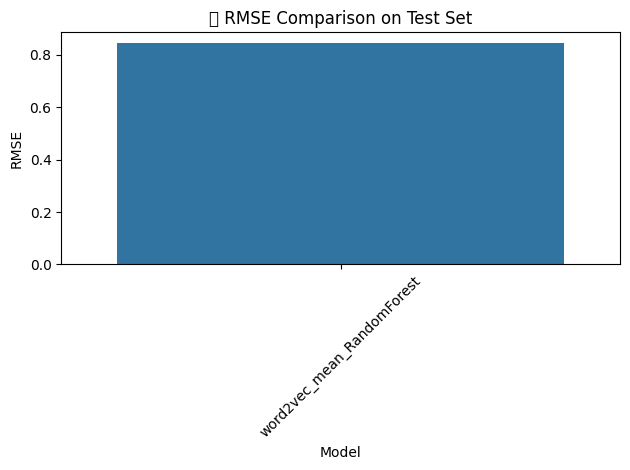

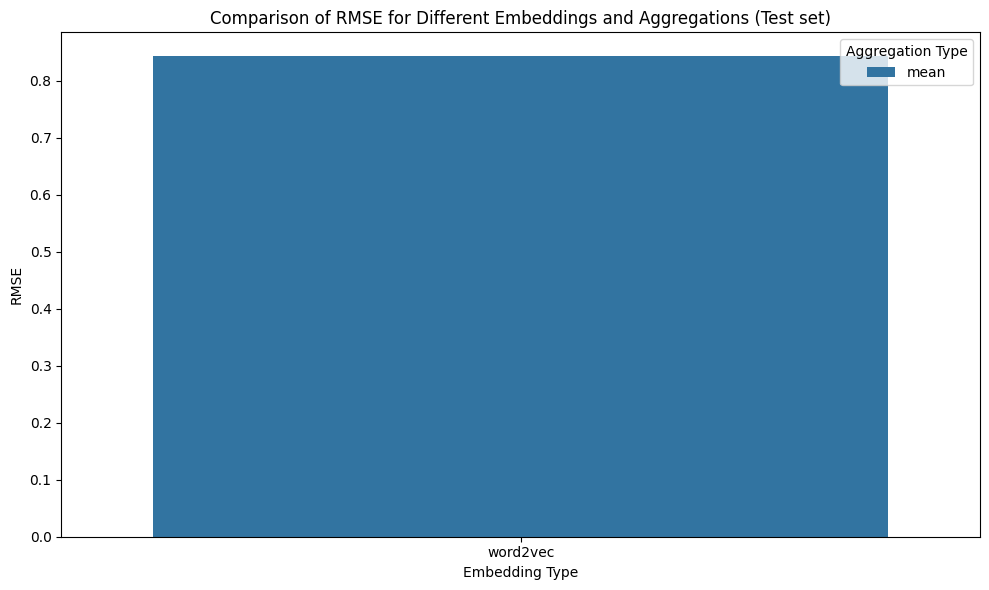

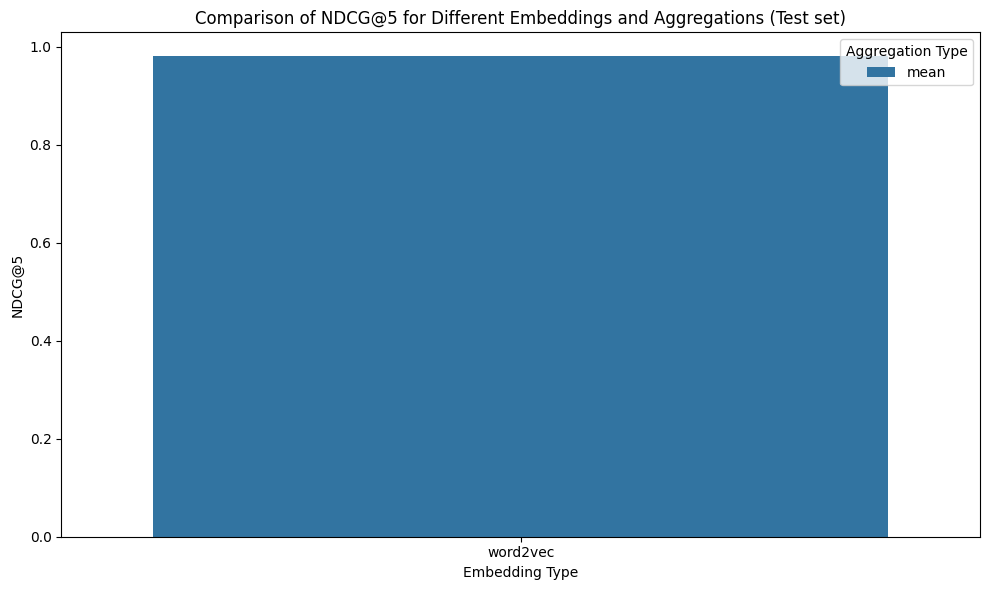

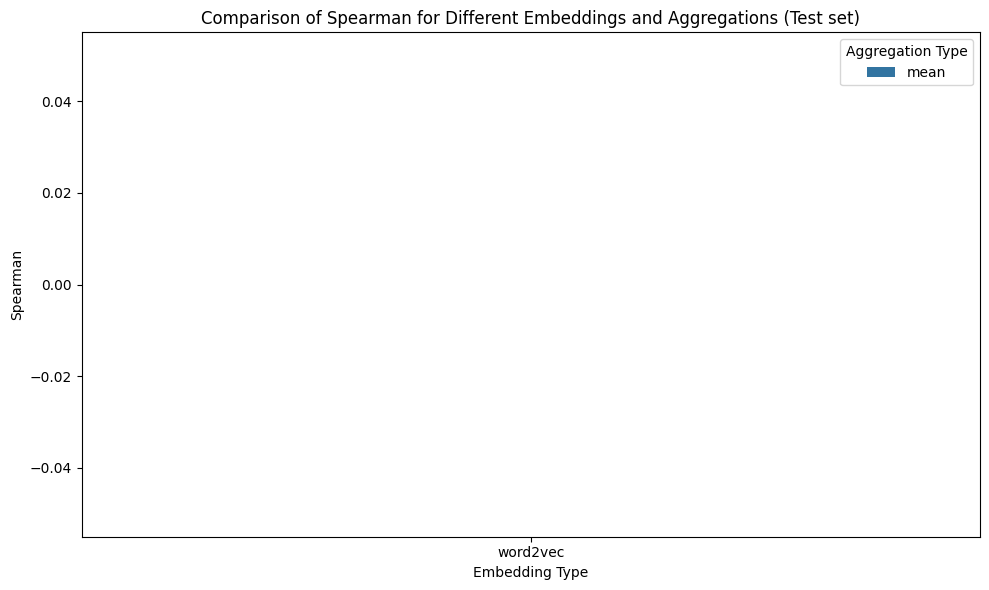

---- Overfitting / Underfitting Analysis ----
Model: word2vec_mean_RandomForest
  Train RMSE: 0.8132
  Validation RMSE: 0.8391
  Difference (Val - Train): 0.0259
  --> No significant over/underfitting detected.


Using best model: word2vec_mean_RandomForest for recommendations

No reviews found for user Tashalee.


[]

In [14]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import spearmanr, kendalltau, pearsonr
from torchmetrics.functional import concordance_corrcoef
import torch
import numpy as np
from sklearn.metrics import ndcg_score
import seaborn as sns
import matplotlib.pyplot as plt

train_df = pd.read_json('train.json', lines=True)
valid_df = pd.read_json('valid.json', lines=True)
test_df = pd.read_json('test.json', lines=True)


def evaluate_regression(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((y_true - y_pred) / y_true )) * 100
    r2 = r2_score(y_true, y_pred)
    ccc = concordance_corrcoef(
        torch.tensor(y_true, dtype=torch.float32),
        torch.tensor(y_pred, dtype=torch.float32)
    ).item()
    pearson = pearsonr(y_true, y_pred)[0]
    ...
    return {
        'MAE': mae, 'RMSE': rmse, 'MAPE': mape, 'R2': r2, 'CCC': ccc, 'Pearson': pearson}


def evaluate_ranking(grouped_df, k_list=[1, 3, 5, 10]):
    ndcg_scores = {f'NDCG@{k}': [] for k in k_list}
    spearmans = []
    kendalls = []

    for _, group in grouped_df.groupby('user_id'):
        if len(group) < 2: continue  # برای محاسبه rank نیاز به حداقل 2 مورد هست
        y_true = group['stars'].values
        y_pred = group['pred'].values

        # برای NDCG نیاز به 2D array داریم
        for k in k_list:
            score = ndcg_score([y_true], [y_pred], k=k)
            ndcg_scores[f'NDCG@{k}'].append(score)

        spearmans.append(spearmanr(y_true, y_pred).correlation)
        kendalls.append(kendalltau(y_true, y_pred).correlation)

    ndcg_mean = {k: np.mean(v) for k, v in ndcg_scores.items()}
    return {
        **ndcg_mean,
        'Spearman': np.mean(spearmans),
        'Kendall': np.mean(kendalls)
    }

def run_full_evaluation(model, embed_fn, df, scaler=None):
    df['tokens'] = df['text'].apply(preprocess)
    X = np.vstack(df['tokens'].apply(embed_fn))

    if scaler:
        X = scaler.transform(X)

    y_true = df['stars'].values
    y_pred = model.predict(X)

    df = df.copy()
    df['pred'] = y_pred

    reg_metrics = evaluate_regression(y_true, y_pred)
    rank_metrics = evaluate_ranking(df)

    return {**reg_metrics, **rank_metrics}

results = []
# ساخت دیکشنری all_models بر اساس پارامترهای انتخاب‌شده
# اگر aggregation_type == 'doc2vec' هست، اول باید doc2vec_model ساخته شده باشه:
if aggregation_type == 'doc2vec':
    tagged = [TaggedDocument(words=t, tags=[str(i)]) for i, t in enumerate(train_df['tokens'])]
    doc2vec_model = Doc2Vec(tagged, vector_size=vector_size, window=window, epochs=epochs, seed=SEED)

# ساخت embed_fn بر اساس aggregation_type
if aggregation_type == 'mean':
    embed_fn = lambda tokens: mean_embedding(tokens, embedding_model)
elif aggregation_type == 'tfidf':
    def embed_fn(tokens):
        df_tmp = pd.DataFrame({'tokens': [tokens], 'text': [' '.join(tokens)]})
        return tfidf_weighted_embedding(df_tmp, embedding_model)[0]
elif aggregation_type == 'doc2vec':
    embed_fn = lambda tokens: doc2vec_model.infer_vector(tokens)
else:
    raise ValueError(f"Unknown aggregation_type: {aggregation_type}")

all_models = {
    f"{embedding_type}_{aggregation_type}_{regressor_type}": {
        'model': regressor,
        'embed_fn': embed_fn,
        'scaler': scaler
    }
}



for name, model_info in all_models.items():  # all_models دیکشنری شامل model, embed_fn, scaler برای هر مدل
    print(f"Evaluating {name}...")
    train_result = run_full_evaluation(model_info['model'], model_info['embed_fn'], train_df, model_info.get('scaler'))
    val_result = run_full_evaluation(model_info['model'], model_info['embed_fn'], valid_df, model_info.get('scaler'))
    test_result = run_full_evaluation(model_info['model'], model_info['embed_fn'], test_df, model_info.get('scaler'))

    for split, result in zip(['Train', 'Validation', 'Test'], [train_result, val_result, test_result]):
        row = {'Model': name, 'Split': split}
        row.update(result)
        results.append(row)

results_df = pd.DataFrame(results)
results_df.to_csv('evaluation_results.csv', index=False)


# مثلاً مقایسه RMSE
sns.barplot(data=results_df[results_df['Split']=='Test'], x='Model', y='RMSE')
plt.xticks(rotation=45)
plt.title("🔍 RMSE Comparison on Test Set")
plt.tight_layout()
plt.show()

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# --- (کدهای قبلی شما) ---

# --- بخش 8: پیشنهاد 10 رستوران برتر برای کاربر Tashalee ---
def recommend_top_k_restaurants(model, embed_fn, df, user_name='Tashalee', scaler=None, k=10):
    # فقط داده‌های کاربر مشخص
    user_df = df[df['user_id'] == user_name].copy()
    if user_df.empty:
        print(f"No reviews found for user {user_name}.")
        return []
    
    # ساخت X برای پیش‌بینی
    user_df['tokens'] = user_df['text'].apply(preprocess)
    X_user = np.vstack(user_df['tokens'].apply(embed_fn))
    if scaler:
        X_user = scaler.transform(X_user)
    
    # پیش‌بینی نمرات برای رستوران‌ها
    preds = model.predict(X_user)
    user_df['pred'] = preds
    
    # میانگین نمره پیش‌بینی شده برای هر رستوران
    top_restaurants = user_df.groupby('business_id')['pred'].mean().sort_values(ascending=False).head(k)
    
    # فرض کنیم اسم رستوران‌ها در ستون business_name باشه
    # اگر نیست، باید دیکشنری یا دیتافریم mapping جداگانه داشته باشیم
    # در غیر اینصورت business_id برمی‌گردانیم
    if 'business_name' in df.columns:
        names = df[['business_id', 'business_name']].drop_duplicates().set_index('business_id')
        top_restaurant_names = names.loc[top_restaurants.index]['business_name'].values
        print(f"Top {k} restaurants recommended for user {user_name}:")
        for i, name in enumerate(top_restaurant_names, 1):
            print(f"{i}. {name}")
        return top_restaurant_names
    else:
        print(f"Top {k} restaurant IDs recommended for user {user_name}:")
        print(top_restaurants.index.tolist())
        return top_restaurants.index.tolist()

# --- بخش 7: بررسی Overfitting و Underfitting ---
def analyze_overfit_underfit(results_df, metric='RMSE'):
    print("---- Overfitting / Underfitting Analysis ----")
    for model_name in results_df['Model'].unique():
        train_val = results_df[(results_df['Model'] == model_name) & (results_df['Split'].isin(['Train', 'Validation']))]
        train_metric = train_val[train_val['Split'] == 'Train'][metric].values[0]
        val_metric = train_val[train_val['Split'] == 'Validation'][metric].values[0]
        diff = val_metric - train_metric
        print(f"Model: {model_name}")
        print(f"  Train {metric}: {train_metric:.4f}")
        print(f"  Validation {metric}: {val_metric:.4f}")
        print(f"  Difference (Val - Train): {diff:.4f}")
        if diff > 0.1 * train_metric:
            print("  --> Possible overfitting detected.")
        elif diff < -0.1 * train_metric:
            print("  --> Possible underfitting detected.")
        else:
            print("  --> No significant over/underfitting detected.")
        print()

# --- بخش 6: تصویرسازی مقایسه embedding ها ---
def plot_embedding_comparisons(results_df, metric_list=['RMSE', 'NDCG@5', 'Spearman']):
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    # از نام مدل‌ها embedding_type استخراج کن
    results_df['Embedding'] = results_df['Model'].apply(lambda x: x.split('_')[0])
    results_df['Aggregation'] = results_df['Model'].apply(lambda x: x.split('_')[1])
    
    for metric in metric_list:
        plt.figure(figsize=(10,6))
        sns.barplot(data=results_df[results_df['Split']=='Test'], x='Embedding', y=metric, hue='Aggregation')
        plt.title(f"Comparison of {metric} for Different Embeddings and Aggregations (Test set)")
        plt.ylabel(metric)
        plt.xlabel('Embedding Type')
        plt.legend(title='Aggregation Type')
        plt.tight_layout()
        plt.show()

# --- اجرا و نمایش نتایج ---

# 1. رسم نمودارهای مقایسه embeddingها
plot_embedding_comparisons(results_df)

# 2. بررسی overfitting و underfitting (مثلا با RMSE)
analyze_overfit_underfit(results_df, metric='RMSE')

# 3. نمایش 10 رستوران برتر برای Tashalee با بهترین مدل (مثلا بهترین مدل روی validation بر اساس RMSE)
best_model_name = results_df[(results_df['Split']=='Validation')].sort_values('RMSE').iloc[0]['Model']
best_model_info = all_models[best_model_name]
print(f"\nUsing best model: {best_model_name} for recommendations\n")
recommend_top_k_restaurants(
    best_model_info['model'], 
    best_model_info['embed_fn'], 
    valid_df, 
    user_name='Tashalee',
    scaler=best_model_info.get('scaler'),
    k=10
)
